In [4]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install tqdm
!pip3 install scipy
!pip3 install pandas
!pip3 install multiprocessing
!pip3 install tqdm

  Using cached multiprocessing-2.6.2.1.tar.gz (108 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-incuneht/multiprocessing_c41de23adec945298933265feabdf33e/setup.py", line 94
          print 'Macros:'
          ^^^^^^^^^^^^^^^
      SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Coarse-graining a stiff macromolecule:

- Generate an ensemble of worm-like macromolecules

Consider a worm-like chain that is comprised of $N$ beads, $r_{i}$ with $i$ = 0, · · · , $N − 1$, or, equivalently, $N − 1$ bonds, $u_{i} = r_{i} − r_{i−1}$ with $i = 1$,··
· ,$N − 1$. The length of each bond is fixed, $\left\lvert u_{i}\right\rvert  = l_{0}$, and there acts a bond-angle potential between successive bonds along the molecular backbone. The energy of a chain configuration takes the form

$$\frac{\mathcal{H}(\{\mathbf{u}\})}{k_{\mathrm{B}} T}=-\frac{\epsilon_0}{l_0^2} \sum_{i=2}^{N-1} \mathbf{u}_i \cdot \mathbf{u}_{i-1}=-\epsilon_0 \sum_{i=2}^{N-1} \hat{\mathbf{u}}_i \cdot \hat{\mathbf{u}}_{i-1}$$



where $\hat{\mathbf{u}}_i$ denotes the direction of bond, $i$. Upon increasing the stiffness parameter, $\epsilon_0$, we favor macromolecules with straight bond angles, i.e., more extended configurations. The probability of a chain configuration, $\left\{\mathbf{u}_i\right\}$, is given by the Boltzmann weight

$$
P_0(\{\mathbf{u}\})=\frac{\exp \left(-\frac{\mathcal{H}\left(\left\{\mathbf{u}_i\right\}\right)}{k_{\mathrm{B}} T}\right)}{\mathcal{Z}}=\frac{1}{\mathcal{Z}} \delta\left(\left|\mathbf{u}_{\mathbf{1}}\right|-l_0\right) \prod_{i=2}^{N-1} e^{\frac{\epsilon_0}{l_0^2} \mathbf{u}_i \cdot \mathbf{u}_{i-1}} \delta\left(\left|\mathbf{u}_{\mathbf{i}}\right|-l_0\right)
$$
where $\mathcal{Z}$ is the normalization (denoted as partition function).


[hints: For the numerics set, $l_0=1$, i.e., measure all length scales in units of $l_0$. Use the parameters, $N=512$ and $\epsilon_0=5$, and generate $n=1048576$ independent molecular conformations.]


a) Generate a large sample of molecular configurations according to Equation 2
- Generate chain configurations by starting with $\mathbf{r}_0=\mathbf{0}$ and $\mathbf{r}_1=\mathbf{u}_1$ uniformly distributed on the sphere with radius, $l_0$. Given $\mathbf{u}_{i-1}$, the probability of $\mathbf{u}_i$ takes the form
$$\begin{aligned}
P\left(\mathbf{u}_i \mid \mathbf{u}_{i-1}\right) \mathrm{d}^3 \mathbf{u}_i & \sim e^{\epsilon_0 \cos \theta} \delta\left(\left|\mathbf{u}_i\right|-l_0^2\right) u_i^2 \mathrm{~d} u_i \mathrm{~d} \cos \theta \mathrm{d} \phi \\
& =\frac{\epsilon_0 e^{\epsilon_0 \cos \theta} \mathrm{d} \cos \theta}{2 \sinh \epsilon_0} \frac{\mathrm{d} \phi}{2 \pi}
\end{aligned}$$ 
where $\theta$ denotes the angle between $\mathbf{u}_i$ and $\mathbf{u}_{i-1}$ (or $l_0 \cos \theta$ is the projection of $\mathbf{u}_i$ onto the $\mathbf{u}_{i-1}$-axis), and $\phi$ is the rotation angle around the $\mathbf{u}_{i-1}$-axis. Describe how you generate the configurations.

- (alternative or bonus if both techniques are used) Write a Monte-Carlo simulation program that employs importance sampling of macromolecular configurations according to Equation 2. For example, use the snake algorithm  by choosing a chain end at random, and try to add a bead at the chosen end and remove a bead from the opposite end. Write down the detailed-balance condition to derive the acceptance criterion.

In [5]:
# Constants
N = 512
epsilon_0 = 5
# n = 1048576
n = 100000
lambdas = [1, 2, 4, 8, 16, 32, 64, 128]

sample_size = n
ensemble_size = n


N, epsilon_0, n

(512, 5, 100000)

In [6]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

def generate_configuration(_):
    # Initialize chain
    r = np.zeros((N, 3))
    u = np.zeros((N - 1, 3))

    # Generate u_1 uniformly distributed on a sphere
    theta = np.arccos(2 * np.random.random() - 1)
    phi = 2 * np.pi * np.random.random()
    u[0] = np.array([np.sin(theta) * np.cos(phi),
                     np.sin(theta) * np.sin(phi),
                     np.cos(theta)])

    # Generate subsequent bonds
    for i in range(1, N - 1):
        while True:
            xi = np.random.uniform(low=0, high=1)
            cos_theta = 2 * xi - 1  # Proposed direction of u_i
            theta = np.arccos(cos_theta)
            phi = 2 * np.pi * np.random.random()
            u_i_proposed = np.array([np.sin(theta) * np.cos(phi),
                                    np.sin(theta) * np.sin(phi),
                                    np.cos(theta)])
            # The probability of u_i given u_{i-1}
            p = np.exp(epsilon_0 * np.dot(u_i_proposed, u[i-1]))
            if np.random.random() < p:  # Acceptance criterion
                u[i] = u_i_proposed
                break
            
            
    # Generate subsequent bonds
    # for i in range(1, N - 1):
    #     xi = np.random.uniform(low=0, high=1)
    #     cos_theta = 2 * xi - 1
    #     theta = np.arccos(cos_theta)
    #     phi = 2 * np.pi * np.random.random()
    #     u_i = np.array([np.sin(theta) * np.cos(phi),
    #                     np.sin(theta) * np.sin(phi),
    #                     np.cos(theta)])
    #     u[i] = u_i            


    return u


# Generate molecular configurations in parallel with progress bar
with Pool() as p, tqdm(total=sample_size) as pbar:
    configurations = []
    for config in p.imap_unordered(generate_configuration, range(sample_size)):
        configurations.append(config)
        pbar.update(1)

# Access individual configurations
print(configurations[0])  # Example: Print the first configuration

100%|██████████| 100000/100000 [02:39<00:00, 627.61it/s]

[[-0.49591117 -0.86533857 -0.07253463]
 [-0.62540126 -0.77934999 -0.03855982]
 [ 0.0236478  -0.09467743  0.99522709]
 ...
 [ 0.57740578  0.16617171 -0.7993682 ]
 [ 0.66399574 -0.74743592  0.02119436]
 [ 0.11705512 -0.75458706 -0.6456752 ]]


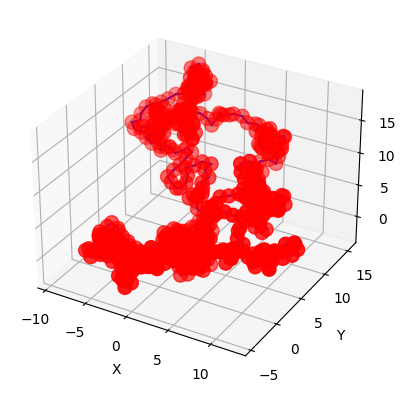

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Access the first configuration
configuration = configurations[0]

# Extract the positions of atoms and bond vectors
positions = np.zeros((N, 3))
bond_vectors = np.zeros((N - 1, 3))

positions[0] = np.array([0, 0, 0])
for i in range(1, N):
    bond_vectors[i - 1] = configuration[i - 1]
    positions[i] = positions[i - 1] + bond_vectors[i - 1]

# Plot the molecular configuration
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot atoms
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='red', s=100)

# Plot bonds
for i in range(N - 1):
    start = positions[i]
    end = positions[i + 1]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='blue')

# Get the limits for the plot
min_coords = np.min(positions, axis=0)
max_coords = np.max(positions, axis=0)

# Set plot limits and labels based on the coordinates
ax.set_xlim([min_coords[0], max_coords[0]])
ax.set_ylim([min_coords[1], max_coords[1]])
ax.set_zlim([min_coords[2], max_coords[2]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


In [8]:
# Save configurations to a file
filename = "chain1.npy"
np.save(filename, configurations)
print(f"Saved {len(configurations)} configurations to {filename}.")

Saved 100000 configurations to chain1.npy.



------

-----

------

-----


------

-----



------

-----
------

-----

------

-----


------

-----



------

-----
------

-----

------

-----


------

-----



------

-----
------

-----

------

-----


------

-----



------

-----
------

-----

------

-----


------

-----



------

-----

In [9]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

def generate_configuration(_):
    # Initialize chain
    r = np.zeros((N, 3))
    u = np.zeros((N - 1, 3))

    # Generate u_1 uniformly distributed on a sphere
    theta = np.arccos(2 * np.random.random() - 1)
    phi = 2 * np.pi * np.random.random()
    u[0] = np.array([np.sin(theta) * np.cos(phi),
                     np.sin(theta) * np.sin(phi),
                     np.cos(theta)])

    # Generate subsequent bonds
    # for i in range(1, N - 1):
    #     while True:
    #         xi = np.random.uniform(low=0, high=1)
    #         cos_theta = 2 * xi - 1  # Proposed direction of u_i
    #         theta = np.arccos(cos_theta)
    #         phi = 2 * np.pi * np.random.random()
    #         u_i_proposed = np.array([np.sin(theta) * np.cos(phi),
    #                                 np.sin(theta) * np.sin(phi),
    #                                 np.cos(theta)])
    #         # The probability of u_i given u_{i-1}
    #         p = np.exp(epsilon_0 * np.dot(u_i_proposed, u[i-1]))
    #         if np.random.random() < p:  # Acceptance criterion
    #             u[i] = u_i_proposed
    #             break
            
            
    # Generate subsequent bonds
    for i in range(1, N - 1):
        xi = np.random.uniform(low=0, high=1)
        cos_theta = 2 * xi - 1
        theta = np.arccos(cos_theta)
        phi = 2 * np.pi * np.random.random()
        u_i = np.array([np.sin(theta) * np.cos(phi),
                        np.sin(theta) * np.sin(phi),
                        np.cos(theta)])
        u[i] = u_i            


    return u


# Generate molecular configurations in parallel with progress bar
with Pool() as p, tqdm(total=sample_size) as pbar:
    configurations2 = []
    for config in p.imap_unordered(generate_configuration, range(sample_size)):
        configurations2.append(config)
        pbar.update(1)

# Access individual configurations
print(configurations2[0])  # Example: Print the first configuration

100%|██████████| 100000/100000 [01:16<00:00, 1303.25it/s]

[[-0.49591117 -0.86533857 -0.07253463]
 [-0.62540126 -0.77934999 -0.03855982]
 [ 0.78808283 -0.01181782 -0.61545576]
 ...
 [-0.07719012 -0.98913859  0.12508612]
 [-0.31442599 -0.42181608  0.85041607]
 [ 0.6257748   0.64645715  0.43646197]]


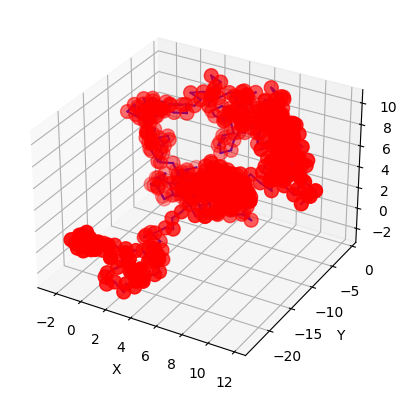

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Access the first configuration
configuration2 = configurations2[0]

# Extract the positions of atoms and bond vectors
positions = np.zeros((N, 3))
bond_vectors = np.zeros((N - 1, 3))

positions[0] = np.array([0, 0, 0])
for i in range(1, N):
    bond_vectors[i - 1] = configuration2[i - 1]
    positions[i] = positions[i - 1] + bond_vectors[i - 1]

# Plot the molecular configuration
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot atoms
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='red', s=100)

# Plot bonds
for i in range(N - 1):
    start = positions[i]
    end = positions[i + 1]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='blue')

# Get the limits for the plot
min_coords = np.min(positions, axis=0)
max_coords = np.max(positions, axis=0)

# Set plot limits and labels based on the coordinates
ax.set_xlim([min_coords[0], max_coords[0]])
ax.set_ylim([min_coords[1], max_coords[1]])
ax.set_zlim([min_coords[2], max_coords[2]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


---------

b) Calculate averages and statistical errors of the following quantities and compare them to the exact results (where available)
- average bond-angle
$$
\langle\cos \theta\rangle=\frac{\left(\epsilon_0-1\right) e^{\epsilon_0}+\left(\epsilon_0+1\right)^{-\epsilon_0}}{2 \epsilon_0 \sinh \epsilon_0}=\frac{1-\frac{1}{\epsilon_0}+\left(1+\frac{1}{\epsilon_0}\right) e^{-2 \epsilon_0}}{1-e^{-2 \epsilon_0}}
$$
- bond-angle correlation along the macromolecule
$$
C(\Delta i)=\frac{\left\langle\mathbf{u}_i \cdot \mathbf{u}_{i+\Delta i}\right\rangle}{l_0^2}=\langle\cos \theta\rangle^{|\Delta i|}=e^{-\frac{l_0|\Delta i|}{l_p}} \quad \text { with } l_p=-\frac{l_0}{\ln \langle\cos \theta\rangle}
$$
where $l_p$ is called the persistence length.
- mean-square end-to-end distance, $\left\langle R_{\mathrm{EE}}^2\right\rangle \equiv\left\langle\left(\mathbf{r}_{N-1}-\mathbf{r}_0\right)^2\right\rangle=\left\langle\left(\sum_{i=1}^{N-1} \mathbf{u}_i\right)^2\right\rangle$
$$
\begin{aligned}
& \left\langle R_{\mathrm{EE}}^2\right\rangle=(N-1) l_0^2\left(\frac{1+\langle\cos \theta\rangle}{1-\langle\cos \theta\rangle}-\frac{2\langle\cos \theta\rangle}{N-1} \frac{1-\langle\cos \theta\rangle^{N-1}}{(1-\langle\cos \theta\rangle)^2}\right) \\
& \stackrel{l_p \gg l_0}{\approx} 2 L l_p\left(1-\frac{l_p}{L}\left[1-e^{-L / l_p}\right]\right) \\
&
\end{aligned}
$$
where $L=(N-1) l_0$ denotes the contour length of the chain molecules.



In [11]:
# Constants
epsilon_0 = 5

# Function to generate a random point on a sphere
def random_point_on_sphere(radius=1):
    theta = 2 * np.pi * np.random.random()  # Uniformly distributed azimuthal angle
    phi = np.arccos(2 * np.random.random() - 1)  # Uniformly distributed polar angle
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return np.array([x, y, z])

# Function to rotate a vector
def rotate_vector(vector, axis, theta):
    """
    Rotate a vector around a given axis by a given angle.
    
    Parameters
    ----------
    vector : array_like
        The vector to rotate.
    axis : array_like
        The axis around which to rotate the vector.
    theta : float
        The angle by which to rotate the vector.
        
    Returns
    -------
    array_like
        The rotated vector.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    rotation_matrix = np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                                [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                                [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    return np.dot(rotation_matrix, vector)

# Function to generate a chain with a directional tendency
def generate_directional_chain_v2(N, epsilon_0, l_0=1):
    chain = [np.array([0, 0, 0])]  # The chain starts at the origin
    u_prev = random_point_on_sphere(radius=l_0)  # u_1
    chain.append(u_prev)
    for i in range(2, N):
        # Generate a random rotation axis perpendicular to u_{i-1}
        axis = np.cross(u_prev, np.random.randn(3))
        axis /= np.linalg.norm(axis)  # Normalize the axis
        # Generate theta from the Boltzmann-like distribution
        u = np.random.random()  # Uniform random number between 0 and 1
        theta = np.arccos(1 - 2 * u) if np.random.random() < 0.5 else np.arccos(2 * u - 1)
        # Rotate u_{i-1} around the random axis by theta to get u_i
        u_i = rotate_vector(u_prev, axis, theta)
        # The probability of u_i given u_{i-1}
        p = np.exp(epsilon_0 * np.dot(u_i, u_prev) / l_0**2)
        if np.random.random() < p:  # Acceptance criterion
            chain.append(u_i)
            u_prev = u_i
    return np.array(chain)

# Function to calculate the end-to-end distance of a chain
def end_to_end_distance(chain):
    return np.linalg.norm(chain[-1] - chain[0])

# Function to calculate the cosine of the angle between the first and last bond of a chain
def cosine_theta(chain):
    u_1 = chain[1] - chain[0]
    u_N = chain[-1] - chain[-2]
    return np.dot(u_1, u_N) / (np.linalg.norm(u_1) * np.linalg.norm(u_N))

# Function to calculate the mean and standard error of a quantity over an ensemble of chains
def mean_and_error(ensemble, quantity_function):
    # Calculate the quantity for each chain in the ensemble
    quantities = np.array([quantity_function(chain) for chain in ensemble])
    # Calculate the mean and standard error
    mean = np.mean(quantities)
    error = np.std(quantities) / np.sqrt(len(quantities))
    return mean, error

# Test the functions by calculating <R>, <cos theta>, and their errors for the ensemble of directional chains
ensemble = [generate_directional_chain_v2(8, epsilon_0) for _ in range(100)]  # Generate an ensemble of 100 chains of length 8
R_mean, R_error = mean_and_error(ensemble, end_to_end_distance)
cos_theta_mean, cos_theta_error = mean_and_error(ensemble, cosine_theta)
R_mean, R_error, cos_theta_mean, cos_theta_error


(1.0, 2.3102244613642865e-17, 0.031131535177648693, 0.06053510029183443)

----------

c) Generate a joint sequence of the polymer's square end-to-end distance, $R_{\mathrm{EE}}^2(t)$, and the bond-angle energy, $\mathcal{H}(\{\mathbf{u}(t)\})$, according to Equation 1. $t$ denotes the index of the configuration in the sequence. Use single-histogram extrapolation
$$
\begin{aligned}
\left\langle R_{\mathrm{EE}}^2\right\rangle_{\epsilon_0^{\prime}} & =\frac{\left\langle e^{\frac{\left(\epsilon_0^{\prime}-\epsilon_0\right)}{l_0^2} \sum_i \mathbf{u}_i \cdot \mathbf{u}_{i-1}} R_{\mathrm{EE}}^2(\{\mathbf{u}\})\right\rangle_\epsilon}{\left\langle e^{\frac{\left(\epsilon_0^{\prime}-\epsilon_0\right)}{l_0^2} \sum_i \mathbf{u}_i \cdot \mathbf{u}_{i-1}}\right\rangle_\epsilon} \\
& \approx \frac{\sum_t e^{\frac{\left(\epsilon_0^{\prime}-\epsilon_0\right)}{l_0^2} \sum_i\left[\mathbf{u}_i(t) \cdot \mathbf{u}_{i-1}(t)-c\right]} R_{\mathrm{EE}}^2(\{\mathbf{u}(t)\})}{\sum_t e^{\frac{\left(\epsilon_0^{\prime}-\epsilon_0\right)}{l_0^2} \sum_i\left[\mathbf{u}_i(t) \cdot \mathbf{u}_{i-1}(t)-c\right]}}
\end{aligned}
$$
to validate your sample of generated configurations by comparing the meansquare end-to-end distance at two, neighboring values of the stiffness parameter, $\epsilon_0^{\prime}$ and $\epsilon_0$. In the last step we have approximated the integral over configuration space by the sum over the sequence. $c \approx\left\langle\mathbf{u}_i \cdot \mathbf{u}_{i-1}\right\rangle=l_0^2\langle\cos \theta\rangle$ is a constant to avoid over/underflow issues.
[hint: choose $\epsilon^{\prime}=\epsilon \pm 0.25$ ]



--------
- Coarse grain the macromolecular configurations
by defining new, coarse-grained bead positions and bond vectors, according to
$$
\mathbf{R}_J=\mathbf{r}_{(J+1 / 2) 2^\lambda} \quad \text { and } \quad \mathbf{U}_J=\mathbf{R}_J-\mathbf{R}_{J-1}=\sum_{i=J 2^\lambda}^{(J+1) 2^\lambda-1} \mathbf{u}_i
$$

where the degree of coarse-graining, $2^\lambda$, is a power of 2 . We seek an approximate description of these coarse-grained configurations, $\mathbf{U}_J$ with $J=1, \cdots, N_\lambda-1$ and $N_\lambda=N / 2^\lambda$, by a probability distribution of the form
$$
P_\lambda(\{\mathbf{U}\}) \sim \mathcal{L}_\lambda\left(\left|\mathbf{U}_1\right|\right) \prod_{J=2}^{N_\lambda-1} e^{\epsilon_\lambda \frac{\mathbf{U}_J \cdot \mathbf{U}_{J-1}}{\sqrt{\mathbf{U}_J^2 \mathbf{U}_{J-1}^2}}} \mathcal{L}_\lambda\left(\left|\mathbf{U}_J\right|\right)=\mathcal{L}_\lambda\left(U_1 \mid\right) \prod_{J=2}^{N_\lambda-1} e^{\epsilon_\lambda} \hat{\mathbf{U}}_J \cdot \hat{\mathbf{U}}_{J-1} \mathcal{L}_\lambda\left(U_J\right)
$$
where $\hat{\mathbf{U}}_J$ and $U_J$ are the direction and the length of the coarse-grained bond, respectively. $\mathcal{L}_\lambda(U)$ denotes the length distribution of a coarse-grained bond and it takes the form
$$
\mathcal{L}_\lambda(U) \sim e^{-\frac{3\left(U-l_\lambda\right)^2}{2 \sigma_\lambda^2}} U^2
$$
Equivalently, the coarse-grained Hamiltonian is of the form
$$
\frac{\mathcal{H}_{\mathrm{cg}}(\{\mathbf{U}\})}{k_{\mathrm{B}} T}=\sum_{J=1}^{N_\lambda-1} \frac{3\left(\left|\mathbf{U}_J\right|-l_\lambda\right)^2}{2 \sigma_\lambda^2}-\epsilon_\lambda \sum_{J=2}^{N_\lambda-1} \hat{\mathbf{U}}_J \cdot \hat{\mathbf{U}}_{J-1}
$$
Thus, the coarse-grained distribution is characterized by 3 parameters, $\epsilon_\lambda, l_\lambda$, and $\sigma_\lambda$. The original probability distribution, $P_1$ for $\lambda=1$, corresponds to $\epsilon_\lambda=\epsilon, l_\lambda=l_0$, and $\sigma_\lambda \rightarrow 0$. The goal of this second part of the exercise is to explicitly show that for $1 \ll \lambda \ll N$, the coarse-grained probability distribution is characterized by $\epsilon_\lambda \rightarrow 0$, $l_\lambda \rightarrow 0$, and $\sigma_\lambda^2 \rightarrow\left\langle R_{\mathrm{EE}}^2\right\rangle /\left(N_\lambda-1\right)$, i.e., the coarse-grained bonds are Gaussian distributed (cf. central limit theorem)
$$
\begin{aligned}
P_\lambda(\{\mathbf{U}\}) \mathrm{d}\{\mathbf{U}\} & \rightarrow \prod_{J=1}^{N_\lambda-1}\left(\frac{3\left(N_\lambda-1\right)}{2 \pi\left\langle R_{\mathrm{EE}}^2\right\rangle}\right)^{3 / 2} e^{-\frac{3\left(N_\lambda-1\right) U_J^2}{2\left\langle R_{\mathrm{EE}}^2\right\rangle}} U_J^2 \mathrm{~d} U_J \mathrm{~d} \phi_J \mathrm{~d} \cos \theta_J \\
& =\left(\frac{3\left(N_\lambda-1\right)}{2 \pi\left\langle R_{\mathrm{EE}}^2\right\rangle}\right)^{3\left(N_\lambda-1\right) / 2} e^{-\frac{3\left(N_\lambda-1\right)}{2\left\langle R_{\mathrm{EE}}^2\right\rangle} \sum_{J=1}^{N_\lambda-1} \mathbf{U}_J^2} \mathrm{~d}\{\mathbf{U}\}
\end{aligned}
$$

--------------
a) Calculate the length distribution, $\mathcal{L}_\lambda(U)$, of the new, coarse-grained bond vectors for various degrees of coarse-graining, $2^\lambda=(1), 2,4,8,16,32,64,128$, and determine the parameters $l_\lambda$ and $\sigma_\lambda^2$ as a function of $2^\lambda$.

In [12]:
def coarse_grain(chain, lambda_):
    """
    Coarse grain a chain configuration.
    
    Parameters
    ----------
    chain : array_like
        The chain configuration to coarse grain.
    lambda_ : int
        The degree of coarse graining.
        
    Returns
    -------
    array_like
        The coarse-grained chain configuration.
    """
    N_lambda = len(chain) // 2**lambda_
    coarse_grained_chain = np.zeros((N_lambda, 3))
    for J in range(N_lambda):
        coarse_grained_chain[J] = np.sum(chain[J*2**lambda_:(J+1)*2**lambda_], axis=0)
    return coarse_grained_chain

# Test the function by coarse graining a chain of length 8 with lambda = 1
coarse_grain(generate_directional_chain_v2(8, epsilon_0), 1)

array([[ 8.55298261e-01, -5.62035084e-04, -5.18135666e-01],
       [ 6.46727484e-01,  8.44161879e-01,  7.87046229e-01]])

In [13]:
from scipy.stats import norm

# Generate an ensemble of chains
N = 512
ensemble_size = 1000
ensemble = [generate_directional_chain_v2(N, epsilon_0) for _ in range(ensemble_size)]

# Define the values of 2^lambda
lambdas = [1, 2, 4, 8, 16, 32, 64, 128]

# Prepare lists to store the results
l_lambda_values = []
sigma_lambda_values = []

# For each value of 2^lambda
for lambda_ in lambdas:
    # Coarse grain the ensemble
    coarse_grained_ensemble = [coarse_grain(chain, lambda_) for chain in ensemble]
    # Calculate the lengths of the coarse-grained bonds
    U_lengths = [np.linalg.norm(U) for chain in coarse_grained_ensemble for U in chain]
    # Fit the lengths to a Gaussian distribution to get l_lambda and sigma_lambda^2
    mu, std = norm.fit(U_lengths)
    l_lambda_values.append(mu)
    sigma_lambda_values.append(std**2)

l_lambda_values, sigma_lambda_values


/root/vsc_projects/PhyforDS/UniKurs_Phy-for-DS/.conda/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:419: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/root/vsc_projects/PhyforDS/UniKurs_Phy-for-DS/.conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/vsc_projects/PhyforDS/UniKurs_Phy-for-DS/.conda/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:424: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


([1.6419299032143273,
  2.5613599941367116,
  5.451468766366386,
  22.165487641820445,
  nan,
  nan,
  nan,
  nan],
 [0.060507451996617855,
  0.43215653440267204,
  4.390863885649659,
  85.95177722996779,
  nan,
  nan,
  nan,
  nan])

--------------
b) Calculate the coarse-grained bond-angle autocorrelation function
$$
C_\lambda(\Delta J)=\left\langle\hat{\mathbf{U}}_J \cdot \hat{\mathbf{U}}_{J+\Delta J}\right\rangle
$$
and estimate from these data the parameter $\epsilon_\lambda$.


In [14]:
# Function to coarse grain a chain configuration
def coarse_grain(chain, lambda_):
    N_lambda = len(chain) // 2**lambda_
    coarse_grained_chain = np.zeros((N_lambda, 3))
    for J in range(N_lambda):
        coarse_grained_chain[J] = np.sum(chain[J*2**lambda_:(J+1)*2**lambda_], axis=0)
    return coarse_grained_chain

def bond_angle_autocorrelation_optimized(ensemble, max_delta_j):
    """
    Calculate the coarse-grained bond-angle autocorrelation function for a given ensemble of coarse-grained chains.
    This optimized version uses NumPy's array operations to calculate the autocorrelation function for all DeltaJ 
    simultaneously.
    
    Parameters
    ----------
    ensemble : array_like
        The ensemble of coarse-grained chains.
    max_delta_j : int
        The maximum difference in index between the bonds.
        
    Returns
    -------
    array_like
        The coarse-grained bond-angle autocorrelation function for all DeltaJ up to max_delta_j.
    """
    # Calculate the unit vectors for each bond in the ensemble
    ensemble_unit_vectors = ensemble / np.linalg.norm(ensemble, axis=2, keepdims=True)
    # Initialize the array to store the autocorrelation function
    C_lambda = np.zeros(max_delta_j)
    # Calculate the autocorrelation function for each DeltaJ
    for delta_j in range(max_delta_j):
        correlations = []
        for chain in ensemble_unit_vectors:
            if len(chain) > 1:  # Only consider chains with a length greater than 1
                if delta_j == 0:
                    correlations.append(np.mean(chain * chain))
                elif delta_j < len(chain) - 1:  # Adjust this line
                    correlations.append(np.mean(chain[:-delta_j] * chain[delta_j:]))
        C_lambda[delta_j] = np.mean(correlations)
    return C_lambda

In [15]:
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np
from scipy.optimize import curve_fit

# Function to fit the autocorrelation function
def fit_func(DeltaJ, xi):
    return np.exp(-DeltaJ / xi)

# Load the pre-generated ensemble of chains
ensemble_array = np.load('chain1.npy')

# Calculate C_lambda(DeltaJ) for various values of DeltaJ and lambda, and estimate epsilon_lambda
DeltaJs = np.arange(1, N // 2)

# Define a helper function for the multiprocessing
def helper_func(args):
    return coarse_grain(*args)

# Function to coarse grain a chain configuration
def coarse_grain(chain, lambda_):
    N_lambda = len(chain) // 2**lambda_
    if N_lambda < 1:  # The chain is too short to be coarse grained
        return None  # Skip this chain
    coarse_grained_chain = np.zeros((N_lambda, 3))
    for J in range(N_lambda):
        coarse_grained_chain[J] = np.sum(chain[J*2**lambda_:(J+1)*2**lambda_], axis=0)
    return coarse_grained_chain

# Coarse grain the chains in parallel with a progress bar for each lambda
with Pool() as p:
    for lambda_ in tqdm(lambdas, desc='Coarse graining chains'):
        coarse_grained_chains = list(p.imap(helper_func, [(chain, lambda_) for chain in ensemble_array]))
        # Filter out None values (chains that were too short to be coarse grained)
        coarse_grained_chains = [chain for chain in coarse_grained_chains if chain is not None]
        coarse_grained_ensemble[lambda_] = np.array(coarse_grained_chains)

# Function to calculate epsilon_lambda for a given lambda
def calculate_epsilon_lambda(lambda_):
    # Get the coarse-grained chains for this lambda
    ensemble = coarse_grained_ensemble[lambda_]
    # Exclude chains with a length of 1
    ensemble = [chain for chain in ensemble if len(chain) > 1]
    # Check if the ensemble is not empty
    if not ensemble:  # The ensemble is empty
        return None  # Return None for epsilon_lambda
    # Calculate C_lambda(DeltaJ) for all DeltaJ up to the length of the shortest coarse-grained chain
    max_delta_j = max(1, min(len(chain) for chain in ensemble) - 1)  # Ensure max_delta_j is at least 1
    C_lambda = bond_angle_autocorrelation_optimized(ensemble, max_delta_j)
    # Fit the autocorrelation function to an exponential decay function
    popt, pcov = curve_fit(fit_func, DeltaJs[:len(C_lambda)], C_lambda, p0=1)
    xi = popt[0]
    # Estimate epsilon_lambda
    epsilon_lambda = 1 / xi
    return epsilon_lambda

# Calculate epsilon_lambda for each lambda with a progress bar
with Pool() as p:
    epsilons = list(tqdm(p.imap(calculate_epsilon_lambda, lambdas), total=len(lambdas), desc='Calculating epsilon_lambda for each lambda'))

epsilons


Calculating epsilon_lambda for each lambda: 100%|██████████| 8/8 [02:19<00:00, 17.39s/it] 


[1.1470511164419692,
 1.213874229182538,
 1.2542277378063655,
 None,
 None,
 None,
 None,
 None]

In [16]:
for lambda_ in lambdas:
    # Coarse grain the ensemble
    coarse_grained_ensemble = [coarse_grain(chain, lambda_) for chain in ensemble]
    # Calculate lengths of the chains after coarse graining
    lengths_after_coarse_graining = [len(chain) for chain in coarse_grained_ensemble]
    # Print the minimum and maximum lengths
    print(f"For lambda={lambda_}, min length={min(lengths_after_coarse_graining)}, max length={max(lengths_after_coarse_graining)}")


For lambda=1, min length=137, max length=171
For lambda=2, min length=68, max length=85
For lambda=4, min length=17, max length=21
For lambda=8, min length=1, max length=1


TypeError: object of type 'NoneType' has no len()

In [ ]:
import pandas as pd

# Create a dictionary with lambda and epsilon_lambda values
data = {'lambda': lambdas, 'epsilon_lambda': epsilons}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Replace None values with NaN
df = df.replace({None: 'NaN'})

df

,lambda,epsilon_lambda
0,1,1.146782
1,2,1.213878
2,4,1.255325
3,8,NaN
4,16,NaN
5,32,NaN
6,64,NaN
7,128,NaN


--------------
c) Graphically represent the variation of $\left(\epsilon_\lambda, l_\lambda, \sigma_\lambda^2 2^{-\lambda}\right)$ as a function of $2^{-\lambda}$-this is called the renormalization group flow.

NameError: name 'l_lambdas' is not defined

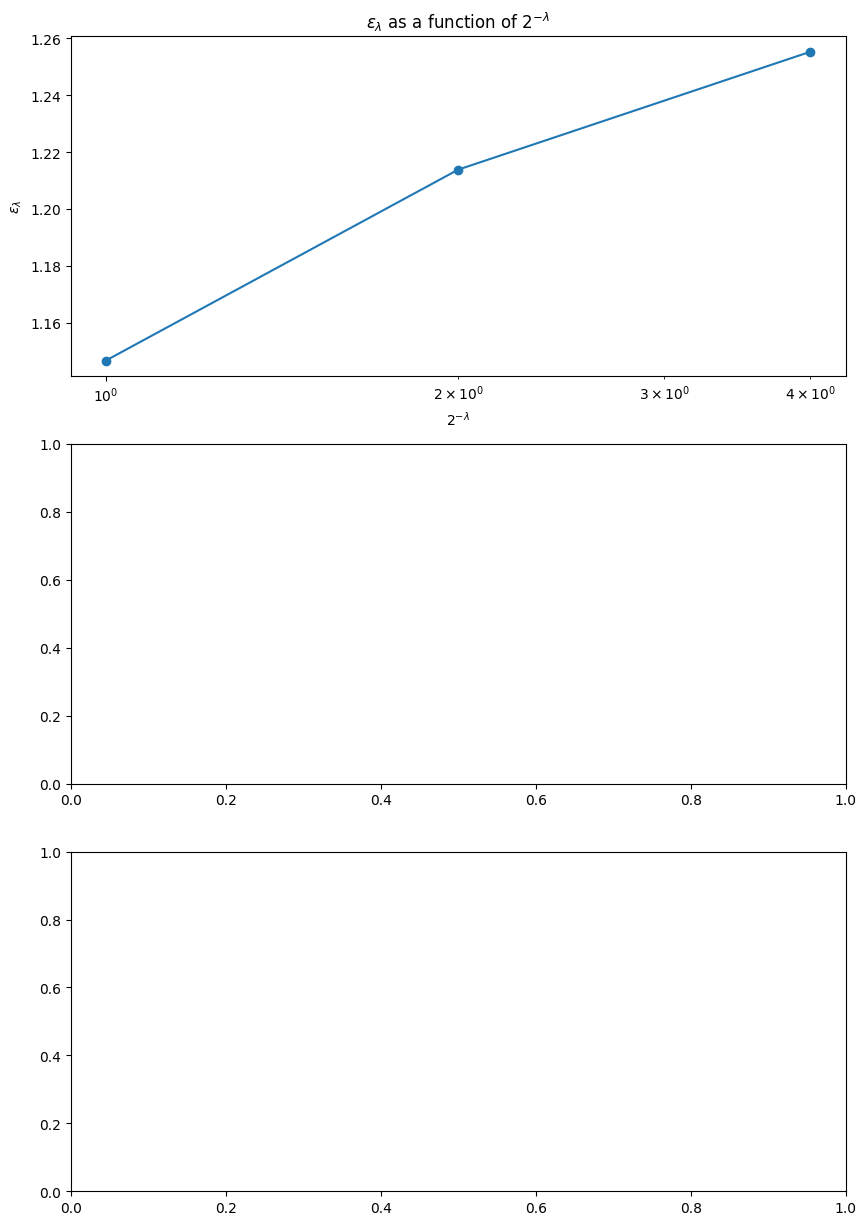

In [ ]:
# Plot epsilon_lambda, l_lambda and sigma_lambda^2 * 2^-lambda as functions of 2^-lambda
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# epsilon_lambda
ax[0].plot(np.array(lambdas), epsilons, marker='o')
ax[0].set_xlabel('$2^{-\lambda}$')
ax[0].set_ylabel('$\epsilon_\lambda$')
ax[0].set_xscale('log')
ax[0].set_title('$\epsilon_\lambda$ as a function of $2^{-\lambda}$')

# l_lambda
ax[1].plot(np.array(lambdas), l_lambdas, marker='o')
ax[1].set_xlabel('$2^{-\lambda}$')
ax[1].set_ylabel('$l_\lambda$')
ax[1].set_xscale('log')
ax[1].set_title('$l_\lambda$ as a function of $2^{-\lambda}$')

# sigma_lambda^2 * 2^-lambda
sigma_lambda_sq_scaled = np.array(sigma_lambdas)**2 / np.array(lambdas)
ax[2].plot(np.array(lambdas), sigma_lambda_sq_scaled, marker='o')
ax[2].set_xlabel('$2^{-\lambda}$')
ax[2].set_ylabel('$\sigma_\lambda^2 2^{-\lambda}$')
ax[2].set_xscale('log')
ax[2].set_title('$\sigma_\lambda^2 2^{-\lambda}$ as a function of $2^{-\lambda}$')

plt.tight_layout()
plt.show()
